In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from IPython.display import display

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
df = pd.read_csv("frg_norm_hssm.csv")
trial_time = 3
stress_dict = {1:'pre',2:'post'}
tt_dict = {5:'short',20:'long'}
leave_resp_filt = df["response"]==0

In [ ]:
# def neg_exp_resp(x,a,b):
#     return a*(1-np.exp(-b*x))

# def cum_rew_func(df,subid,stress_cond,tt_cond,ax,c):
#     subid_filt = df["subj_idx"]==subid

#     ##Correcting for abrupt tt_cond changes:
#     patch_leave_idx = pd.Index(df[subid_filt & leave_resp_filt].index)
#     patch_entry_idx = pd.Index([df[subid_filt].index[0]]+list(patch_leave_idx+1))
#     patch_trial_idx = [list(range(i,j+1)) for (i,j) in list(zip(patch_entry_idx,patch_leave_idx))]
#     for idxs in patch_trial_idx:
#         if len(df.loc[idxs]["travel_time"].unique())>1:
#             tmp = df.loc[idxs]["travel_time"]
#             df.at[idxs,"travel_time"] = df.loc[idxs[-1]]["travel_time"]
#     ##

#     stress_filt = df["condition"]==stress_cond
#     tt_filt = df["travel_time"]==tt_cond

#     patch_leave_idx = pd.Index(df[subid_filt & stress_filt & tt_filt & leave_resp_filt].index)
#     patch_entry_idx = pd.Index([df[subid_filt & stress_filt & tt_filt].index[0]]+list(patch_leave_idx+1))
#     patch_trial_idx = [list(range(i,j+1)) for (i,j) in list(zip(patch_entry_idx,patch_leave_idx))]
#     patch_lens = [len(i) for i in patch_trial_idx]
#     num_trials = sum(patch_lens)
#     long_patch_len = max(patch_lens)
#     num_patches = len(patch_trial_idx)

#     # rel_patch_trial_idx = [np.array(i)-i[0] for i in patch_trial_idx]
#     rel_trial_idx = [list(np.array(i)-patch_trial_idx[0][0]) for i in patch_trial_idx]
#     rel_leave_idx = list(patch_leave_idx - patch_entry_idx[0])

#     tot_rew = np.concatenate(([list(df.loc[i]["tot_reward"]) for i in patch_trial_idx]))
#     tot_rew = tot_rew-tot_rew[0]

#     x_data = np.array([0]+[trial_time]*num_trials)
#     x_data[np.array(rel_leave_idx)] = tt_cond
#     x_data = np.cumsum(x_data[:-1])

#     patch_cum_rew = [list(tot_rew[i]) for i in rel_trial_idx]

#     y_data = tot_rew
#     reg = LinearRegression(fit_intercept=False).fit(x_data.reshape(-1,1),y_data.reshape(-1,1))
#     slope = reg.coef_; slope = slope.flatten()

#     ax.plot(x_data,x_data*slope,'--'+c)
#     ax.plot(x_data,y_data,'.-'+c,label=str(subid)+' '+str(stress_dict[stress_cond])+str(tt_dict[tt_cond]))
    
#     stay_lock_patch_rew = np.nan*np.ones((num_patches,long_patch_len))
#     patch_rew = [np.array(i)-i[0] for i in patch]
#     for i in range(num_patches):
#         stay_lock_patch_rew[i] = list(patch_rew[i])+(long_patch_len-len(patch_rew[i]))*[np.nan]
#     mean_rew = np.nanmean(stay_lock_patch_rew,0)
    
#     popt,pcov = [],[]
#     try:
#         popt, pcov = curve_fit(neg_exp_resp, x_data[:len(mean_rew)],mean_rew)
#         ax.plot(x_data[:len(mean_rew)],neg_exp_resp(x_data[:len(mean_rew)],*popt),'-'+c)
#     except RuntimeError:
#         pass
#     ax.plot(x_data,x_data*slope,'--'+c,label=str(subid)+' '+str(stress_dict[stress_cond])+str(tt_dict[tt_cond]))
# #     ax.plot(x_data,y_data,'-'+c,label=str(subid)+' '+str(stress_dict[stress_cond])+str(tt_dict[tt_cond]))
#     ax.plot(x_data[:len(mean_rew)],mean_rew[:],'.'+c)
#     ax.legend()
#     return tot_rew,patch_cum_rew,popt,ax

In [ ]:
# fig,ax=plt.subplots()

In [ ]:
# cum_rew_func_params = []

# subid = 7873;

# # stress = 1; tt = 5;  preshort_env_rew,  preshort_patch_rew,  opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C0'); cum_rew_func_params.append(opt_params)
# stress = 1; tt = 20; prelong_env_rew,   prelong_patch_rew,   opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C1'); cum_rew_func_params.append(opt_params)
# # stress = 2; tt = 5;  postshort_env_rew, postshort_patch_rew, opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C2'); cum_rew_func_params.append(opt_params)
# stress = 2; tt = 20; postlong_env_rew,  postlong_patch_rew,  opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C3'); cum_rew_func_params.append(opt_params)

# # subid = 15089;
# # 
# # stress = 1; tt = 5;  preshort_env_rew,  preshort_patch_rew,  opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C4'); cum_rew_func_params.append(opt_params)
# # stress = 1; tt = 20; prelong_env_rew,   prelong_patch_rew,   opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C5'); cum_rew_func_params.append(opt_params)
# # stress = 2; tt = 5;  postshort_env_rew, postshort_patch_rew, opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C6'); cum_rew_func_params.append(opt_params)
# # stress = 2; tt = 20; postlong_env_rew,  postlong_patch_rew,  opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C7'); cum_rew_func_params.append(opt_params)

# # subid = 45194;

# # stress = 1; tt = 5;  preshort_env_rew,  preshort_patch_rew,  opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C8'); cum_rew_func_params.append(opt_params)
# # stress = 1; tt = 20; prelong_env_rew,   prelong_patch_rew,   opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C9'); cum_rew_func_params.append(opt_params)
# # stress = 2; tt = 5;  postshort_env_rew, postshort_patch_rew, opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C10'); cum_rew_func_params.append(opt_params)
# # stress = 2; tt = 20; postlong_env_rew,  postlong_patch_rew,  opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C11'); cum_rew_func_params.append(opt_params)

# preshort_patch_rew
# # np.mean([[preshort_patch_rew],[prelong_patch_rew],[postshort_patch_rew],[postlong_patch_rew]],0)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]] 

 [[0.0, 0.0162082616489301, 0.0311856733501856, 0.0446857235895333, 0.057670334259682, 0.0696657500285403, 0.0807860814122912, 0.0905759934786117, 0.0986607030241167, 0.0986607030241167], [0.1163532541300773, 0.1334513305159951, 0.1490181122105307, 0.1634290457198932, 0.1763237215491393, 0.1871261479329284, 0.1967677247128504, 0.2054278246900177, 0.2122183958890375, 0.2122183958890375], [0.2313156774237626, 0.2492602369205561, 0.2668922640939493, 0.2830270622372345, 0.2972316831020782, 0.31016942847621, 0.322568984595023, 0.3346327912814709, 0.3455926052797075, 0.3558210609868568, 0.3651532217620756, 0.3739192239245144, 0.3739192239245144]]


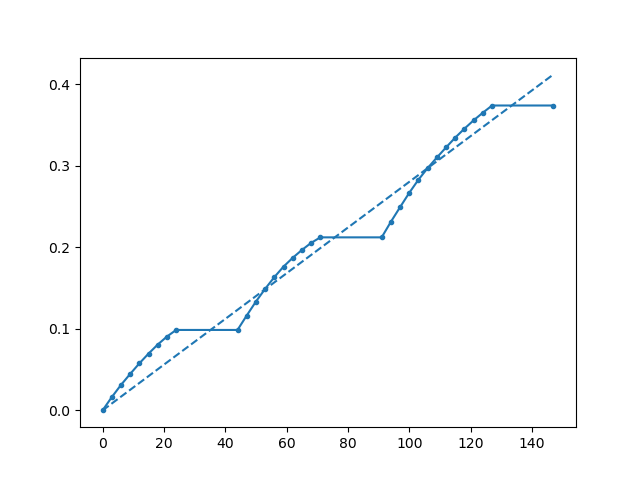

In [43]:
##Sections for testing:

subid = 7873; 

stress_cond = 2; tt_cond = 20; c='C0'

subid_filt = df["subj_idx"]==subid

##Correcting for abrupt tt_cond changes:
patch_leave_idx = pd.Index(df[subid_filt & leave_resp_filt].index)
patch_entry_idx = pd.Index([df[subid_filt].index[0]]+list(patch_leave_idx+1))
patch_trial_idx = [list(range(i,j+1)) for (i,j) in list(zip(patch_entry_idx,patch_leave_idx))]
for idxs in patch_trial_idx:
    if len(df.loc[idxs]["travel_time"].unique())>1:
        tmp = df.loc[idxs]["travel_time"]
        df.at[idxs,"travel_time"] = df.loc[idxs[-1]]["travel_time"]
##

stress_filt = df["condition"]==stress_cond
tt_filt = df["travel_time"]==tt_cond

patch_leave_idx = pd.Index(df[subid_filt & stress_filt & tt_filt & leave_resp_filt].index)
patch_entry_idx = pd.Index([df[subid_filt & stress_filt & tt_filt].index[0]]+list(patch_leave_idx+1))
patch_trial_idx = [list(range(i,j+1)) for (i,j) in list(zip(patch_entry_idx,patch_leave_idx))]
patch_lens = [len(i) for i in patch_trial_idx]
num_trials = sum(patch_lens)
long_patch_len = max(patch_lens)
num_patches = len(patch_trial_idx)

# rel_patch_trial_idx = [np.array(i)-i[0] for i in patch_trial_idx]
rel_trial_idx = [list(np.array(i)-patch_trial_idx[0][0]) for i in patch_trial_idx]
rel_leave_idx = list(patch_leave_idx - patch_entry_idx[0])

tot_rew = np.concatenate(([list(df.loc[i]["tot_reward"]) for i in patch_trial_idx]))
tot_rew = tot_rew-tot_rew[0]

x_data = np.array([0]+[trial_time]*num_trials)
x_data[np.array(rel_leave_idx)] = tt_cond
x_data = np.cumsum(x_data[:-1])

patch_cum_rew = [list(tot_rew[i]) for i in rel_trial_idx]
print(rel_trial_idx,'\n\n',patch_cum_rew)

y_data = tot_rew

reg = LinearRegression(fit_intercept=False).fit(x_data.reshape(-1,1),y_data.reshape(-1,1))
slope = reg.coef_; slope = slope.flatten()

fig,ax=plt.subplots()
ax.plot(x_data,x_data*slope,'--'+c)
ax.plot(x_data,y_data,'.-'+c,label=str(subid)+' '+str(stress_dict[stress_cond])+str(tt_dict[tt_cond]))

In [44]:
patch_rew = [np.array(i)-i[0] for i in patch_cum_rew]
#stay_lock
stay_lock_patch_rew = np.nan*np.ones((num_patches,long_patch_len))
for i in range(num_patches):
    stay_lock_patch_rew[i] = list(patch_rew[i])+(long_patch_len-len(patch_rew[i]))*[np.nan]
# print(stay_lock_patch_rew)

def neg_exp_resp(x,a,b):
    return a*(1-np.exp(-b*x))

mean_rew = np.nanmean(stay_lock_patch_rew,0)
fit_x = [0]+[trial_time]*len(mean_rew); fit_x = np.cumsum(fit_x[:-1])

ax.plot(fit_x,mean_rew[:],'.k')

popt, pcov = curve_fit(neg_exp_resp,fit_x,mean_rew)
ax.plot(fit_x,neg_exp_resp(fit_x,*popt))
# opt = popt
sub_popt = []
for i in range(num_patches):
    fit_x = [0]+[trial_time]*len(patch_rew[i]); fit_x = np.cumsum(fit_x[:-1])    
    popt, pcov = curve_fit(neg_exp_resp,fit_x,patch_rew[i])
    sub_popt.append(popt)
    # ax.plot(x_data[:len(patch_cum_rew[i])],patch_cum_rew[i],'--'+c)#,label="Patch {}".format(patch_num))
    # ax.plot(x_data[:len(patch_cum_rew[i])],neg_exp_resp(x_data[:len(patch_cum_rew[i])],*popt),'-'+c)

sub_popt = np.array(sub_popt)
opt = np.mean(sub_popt,0)
# opt = sub_popt[np.where(sub_popt[:,1]==max(sub_popt[:,1]))[0]][0]
# print(sub_popt[np.where(sub_popt[:,1]==max(sub_popt[:,1]))[0]],'\n',opt)

In [ ]:
# patch_len = [0]+[len(i) for i in patch_cum_rew]
# patch_len = np.cumsum(patch_len)
# idxs = [np.array(range(i,j)) for (i,j) in list(zip(patch_len[:-1],patch_len[1:]))]

# trial_idxs = [np.array(i)-patch_trial_idx[0][0] for i in patch_trial_idx]
rel_trial_idxs = [np.array(i)-i[0] for i in rel_trial_idx]
print(trial_idxs,rel_trial_idxs)
y = []
for i in range(num_patches):
    x = x_data[rel_trial_idxs[i]]
#     print(x)
    if i==0:
        patch_x = x
    else:
        patch_x = x_data[np.array(rel_trial_idxs[i])+1]
    patch_y = neg_exp_resp(patch_x,*opt)
    patch_y[-1]=patch_y[-2]
    y.append(patch_y)

#Offset rewards:
for i in range(1,num_patches):
    y[i]=np.array(y[i])+y[i-1][-1]

for i in range(num_patches):
    x = x_data[trial_idxs[i]]
    ax.plot(x,y[i],'-C1')

In [45]:
#Synthetic data for optimal calculation

n=1
def mvt_opt(n_stay,num_trials,tt_cond,opt,ax,c):
    leave_locs=[0]
    while len(leave_locs)<=num_trials:
        leave_locs+=([0]*n_stay+[1])

    leave_idxs = np.where(np.array(leave_locs)==1)[0]
    leave_idxs = leave_idxs[leave_idxs<num_trials]
    entry_idxs = np.array([0]+list(leave_idxs[:-1]+1))
    entry_idxs = entry_idxs[entry_idxs<num_trials]

    t_data = np.array([trial_time]*num_trials);t_data[0]=0
    t_data[leave_idxs] = tt_cond; t_data = np.cumsum(t_data);
    t_data = t_data[t_data<x_data[-1]]
    leave_idxs = leave_idxs[leave_idxs<len(t_data)]
    entry_idxs = entry_idxs[entry_idxs<len(t_data)]

    trial_idxs = [list(range(i,j)) for (i,j) in list(zip(entry_idxs[:-1],entry_idxs[1:]))]
    rel_trial_idxs = [np.array(i)-i[0] for i in trial_idxs]
    num_patch = len(trial_idxs)

    y = []
    for i in range(num_patch):
        t = t_data[trial_idxs[i]]
#         print(t)
        if i==0:
            patch_x = t_data[np.array(rel_trial_idxs[i])]
        else:
            patch_x = t_data[np.array(rel_trial_idxs[i])+1]
        patch_y = neg_exp_resp(patch_x,*opt)
        patch_y[-1]=patch_y[-2]
        y.append(patch_y)

    for i in range(1,num_patch):
        y[i]=np.array(y[i])+y[i-1][-1]

    for i in range(num_patch):
        t = t_data[trial_idxs[i]]
        r = y[i]
#         ax.plot(t,r,c)
    rew = np.concatenate([i for i in y])
    reg = LinearRegression(fit_intercept=False).fit(t_data[:len(rew)].reshape(-1,1),rew.reshape(-1,1))
    slope = reg.coef_; slope = slope.flatten()
    ax.plot(t_data,slope*t_data,c,label="{}".format(n_stay))
    return [rew,slope]

sub_num_trials = num_trials
# fig,ax=plt.subplots()
# mvt_opt(3,sub_num_trials,opt,ax,'C'+str(i))

cum_res = []
for i in range(1,10):
    [n_rew,n_rate] = mvt_opt(i,sub_num_trials,tt_cond,opt,ax,colors[i])
    cum_res.append([n_rew,n_rate])
ax.legend()

In [ ]:
# print(np.shape(cum_res))
# print([len(i) for i in cum_res])
# fig2,ax2=plt.subplots()
# ax2.plot(range(1,10),np.array(cum_res)[:,0])
# np.concatenate(([0],[1,2,3]))
# np.concatenate(([0],*[list(df.loc[i]["tot_reward"]) for i in patch_trial_idx]))

# display(df.loc[patch_trial_idx[0]])
# idxs = patch_tr
# df.loc[idxs]["travel_time"]

df.loc[patch_trial_idx[0][0]-1][["subj_idx","travel_time","tot_reward"]]
df.loc[patch_trial_idx[0][0]]["travel_time"]
a=[1,2,3,4,5]
[i-i[0] for i in a]